In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns


In [2]:
import warnings         # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings("ignore")

## Dataset and visualisation

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

In [4]:
testset = torchvision.datasets.MNIST(root='./data', train=False, 
                                        download=True, 
                                        transform=transforms.ToTensor())

In [5]:
batch_size = 4

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [7]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
6


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
9


In [10]:
def imshow(img, title):
    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [11]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

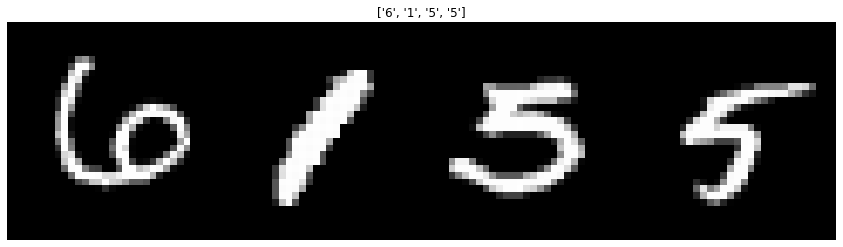

In [12]:
images, labels = show_batch_images(trainloader)

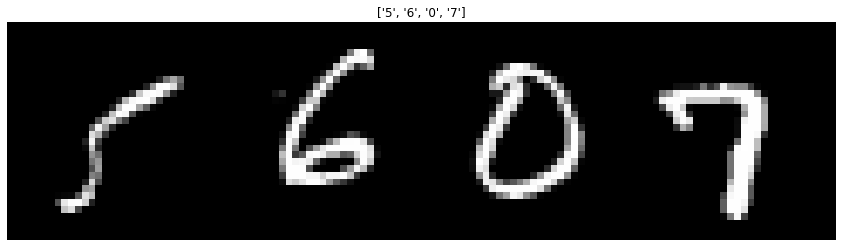

In [13]:
images, labels = show_batch_images(testloader)

## Batchnorm

Вспоминаем смысл batchnorm. Мы усредняем

In [14]:
class MyNet(nn.Module):
    def __init__(self): 
        super(MyNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

In [15]:
class MyNetBN(nn.Module):
    def __init__(self): 
        super(MyNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

In [16]:
model = MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [17]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [18]:
batch_size = 512

In [19]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [20]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

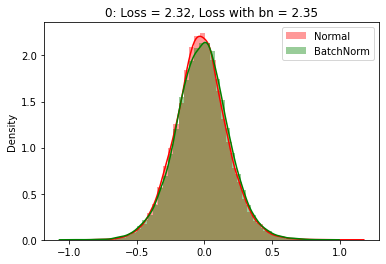

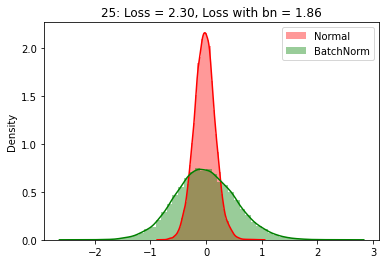

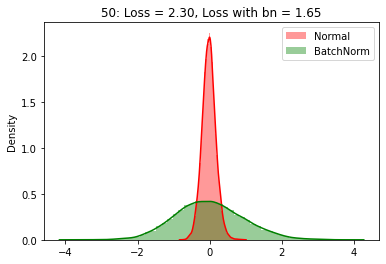

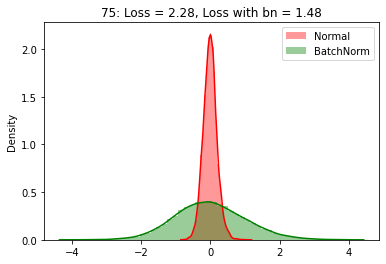

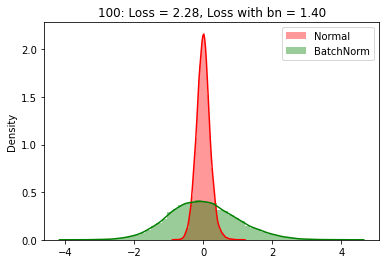

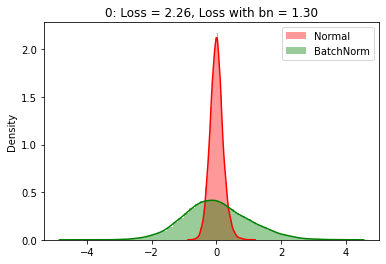

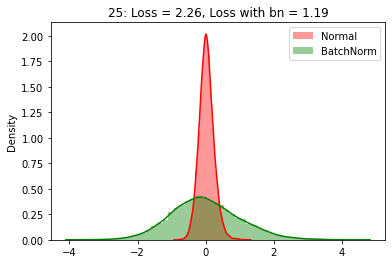

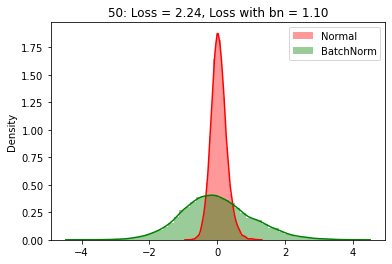

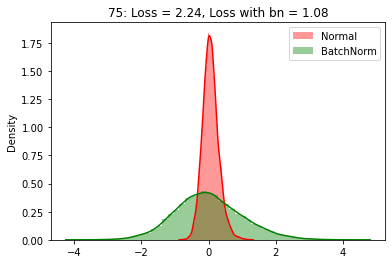

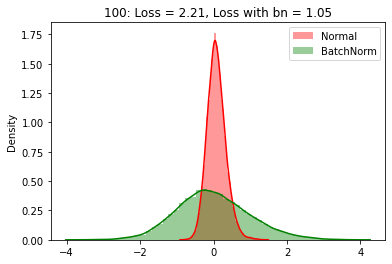

----------------------


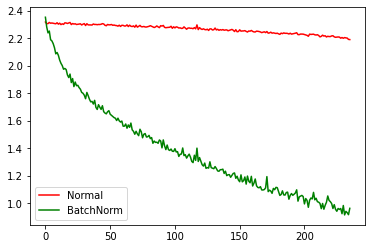

In [21]:
loss_arr = []
loss_bn_arr = []

loss_arr_test = []
loss_bn_arr_test = []

max_epochs = 2

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        model.eval()
        model_bn.eval()
        inputs_test, labels_test = next(iter(testloader))
        test_pred = model(inputs_test)
        test_loss = loss_fn(test_pred, labels_test)
        test_pred_bn = model_bn(inputs_test)
        test_loss_bn = loss_fn(test_pred_bn, labels_test)
        loss_arr_test.append(test_loss.item())
        loss_bn_arr_test.append(test_loss_bn.item())
        
        model.train()
        model_bn.train()
        
        if i % 25 == 0:
        
            inputs = inputs.view(inputs.size(0), -1)
            
            model.eval()
            model_bn.eval()
            
            a = model.classifier[0](inputs)
#             a = model.classifier[1](a)
#             a = model.classifier[2](a)
            a = a.detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r', label='Normal') 
            
            b = model_bn.classifier[0](inputs)
            b = model_bn.classifier[1](b)
#             b = model_bn.classifier[2](b)
#             b = model_bn.classifier[3](b)
#             b = model_bn.classifier[4](b)
            b = b.detach().numpy().ravel()
            
            sns.distplot(b, kde=True, color='g', label='BatchNorm') 
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)
            
            
            
            
            
            model.train()
            model_bn.train()
            
        
        
print('----------------------')

plt.plot(loss_arr, 'r', label='Normal')
plt.plot(loss_bn_arr, 'g', label='BatchNorm')
plt.legend()
plt.show()

----------------------


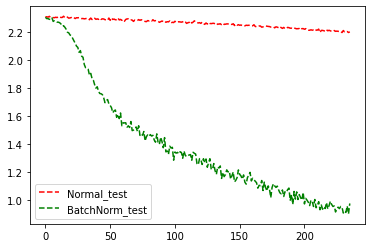

In [22]:
print('----------------------')

# plt.plot(loss_arr, 'r', label='Normal')
# plt.plot(loss_bn_arr, 'g', label='BatchNorm')
plt.plot(loss_arr_test, 'r--', label='Normal_test')
plt.plot(loss_bn_arr_test, 'g--', label='BatchNorm_test')

plt.legend()
plt.show()

[link text](https://)Такс - а теперь давайте реализуем 3х слойную сеточку с Batchnorm в серединке сетки.
Размерности следующие - 64,48,24 нейрона на каждом слое.

In [23]:
### Ваш код здесь

## Dropout

Данный прием отключает наш нейрон в сеточке при обучении с какой-то вреоятностью. Давайте посмотрим на практике, как это работает

In [24]:
N = 50
noise = 0.3

X_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_train = X_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

X_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_test = X_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

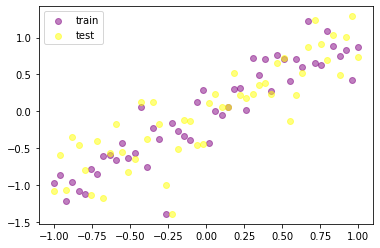

In [25]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [26]:

N_1 = 100
N_2 = 60 
p = 0.2
# dropout добавляется следующей командой torch.nn.Dropout()
# модель можно создать просто model_without_drop = torch.nn.Sequential()
# Нашим заданием будет создать 2 модельки model_without_drop и model_dropout. с N_1 и N_2 количеством нейронов

model = nn.Sequential(nn.Linear(1, N_1),
                      nn.ReLU(),
                      nn.Linear(N_1, N_2),
                      nn.ReLU(),
                      nn.Linear(N_2, 1))

model_dropout = nn.Sequential(nn.Linear(1, N_1),
                      nn.ReLU(),
                      nn.Dropout(p),
                      nn.Linear(N_1, N_2),
                      nn.ReLU(),
                      nn.Dropout(p),
                      nn.Linear(N_2, 1))


In [27]:
# Оптимизаторы возьмем Adam, а минимизировать будем MSE

opt = torch.optim.AdamW(model.parameters(), lr=0.01)
opt_dropout = torch.optim.AdamW(model_dropout.parameters(), lr=0.01)

loss_fn = nn.MSELoss()

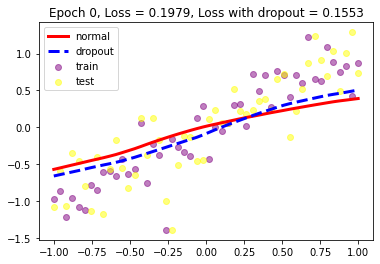

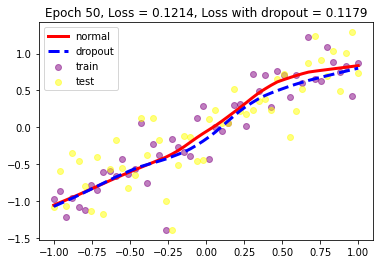

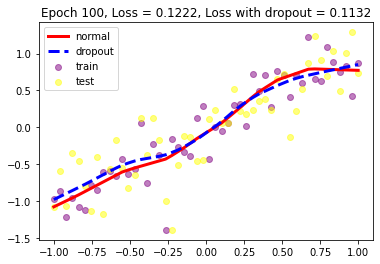

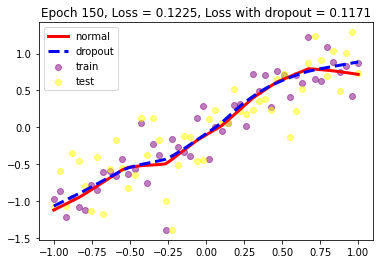

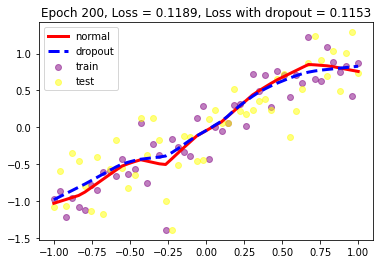

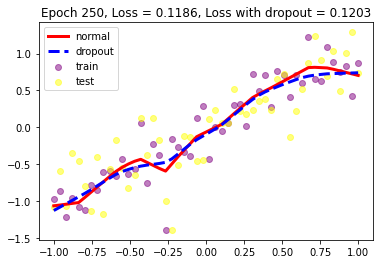

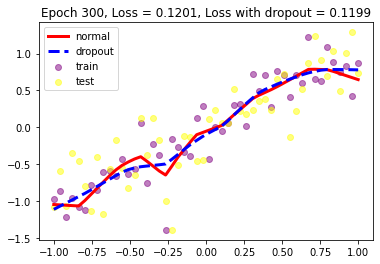

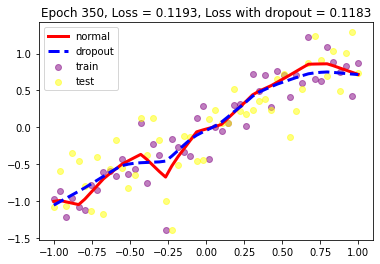

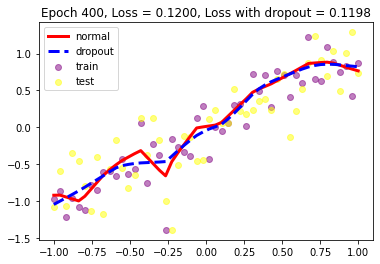

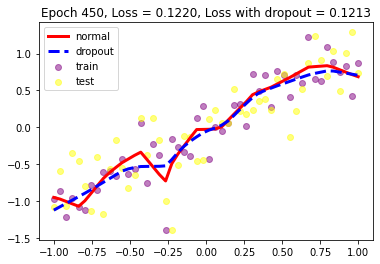

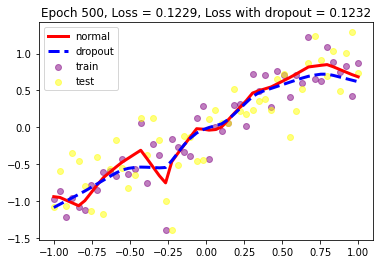

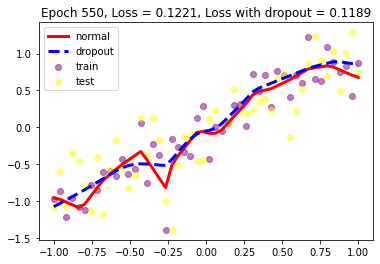

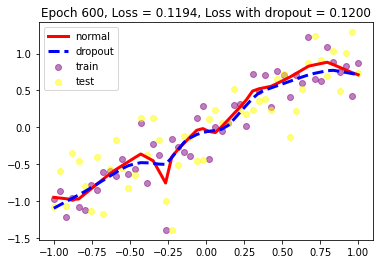

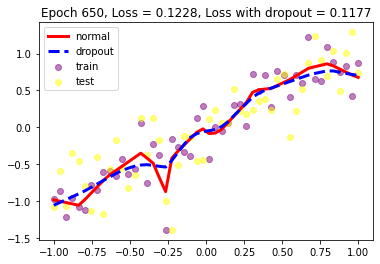

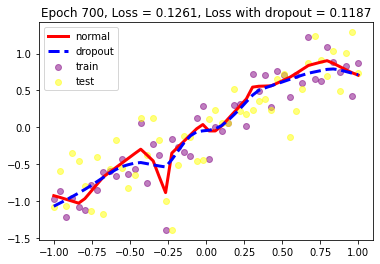

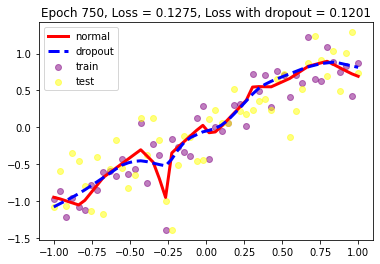

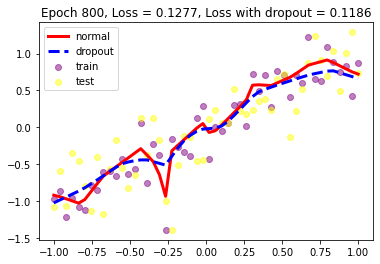

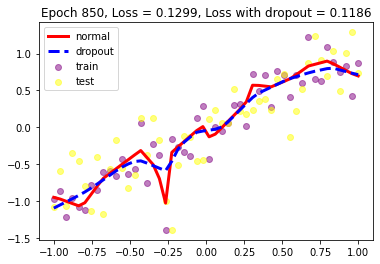

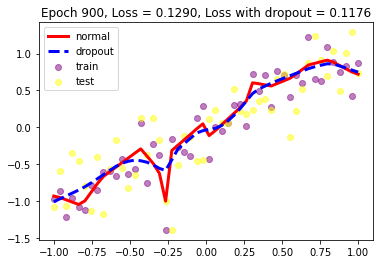

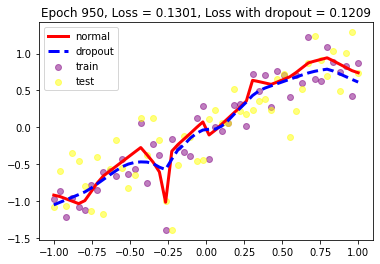

In [28]:
max_epochs = 1000

for epoch in range(max_epochs):
    opt.zero_grad()
    
    pred = model(X_train) 
    loss = loss_fn(pred, Y_train)
    loss.backward()
    opt.step()
    
    pred_dropout = model_dropout(X_train)
    loss_dropout = loss_fn(pred_dropout, Y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()
    
    
    if epoch % 50 == 0:
        
        model.eval()
        model_dropout.eval()
        
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, Y_test)
        
        test_pred_dropout = model_dropout(X_test)
        test_loss_dropout = loss_fn(test_pred_dropout, Y_test)
        
        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='normal')
        plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        
        plt.legend()

        model.train()
        model_dropout.train()
        
        plt.pause(0.05)

### Инициализация

Хорошая инициализация весов нам нужна, чтобы наш сигнал не терялся и не разлетался в глубоких сетках. 
Для этого мы пытаемся сохранить постоянную дисперсию между слоями. 

In [29]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [30]:

# Добавим еще обучение по сценарию
from torch.optim.lr_scheduler import StepLR



class FeedforwardNeuralNetModel_with_Kaiming(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Linear weight, W,  Y = WX + B
        nn.init.kaiming_normal_(self.fc1.weight)
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
    

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Linear weight, W,  Y = WX + B
        nn.init.normal_(self.fc1.weight, mean=0, std=1)
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
        nn.init.normal_(self.fc2.weight, mean=0, std=1)
        

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
    

input_dim = 28*28
hidden_dim = 100
output_dim = 10

model_he = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
model_simple = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)




loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer_simple = torch.optim.SGD(model_simple.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
optimizer_he = torch.optim.SGD(model_he.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

# step_size: Как часто мы будем уменьшать наш LR
# step_size = 1,осле каждой эпохи new_lr = lr*gamma 
# step_size = 2, п  new_lr = lr*gamma 

# gamma = насколько сильно снижаем
scheduler_simple = StepLR(optimizer_simple, step_size=1, gamma=0.96)
scheduler_he = StepLR(optimizer_he, step_size=1, gamma=0.96)

'''
TRAIN THE MODEL
'''


num_epochs = 50
loss_arr_simple = []
loss_arr_he = []

acc_arr_simple = []
acc_arr_he = []
iterations = 0
for epoch in range(num_epochs):
    # Decay Learning Rate
    scheduler_simple.step()
    scheduler_he.step()
    # Print Learning Rate
    print('Epoch:', epoch,'LR:', scheduler_simple.get_lr())
    for i, (images, labels) in enumerate(trainloader):
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, 28*28)
        
        # training steps for normal model
        optimizer_simple.zero_grad()
        outputs_simple = model_simple(images)
        loss_simple = loss_fn(outputs_simple, labels)
        loss_simple.backward()
        optimizer_simple.step()
        
       # train step for He ini
        optimizer_he.zero_grad()
        outputs_he = model_he(images)
        loss_he = loss_fn(outputs_he, labels)
        loss_he.backward()
        optimizer_he.step()
        
        loss_arr_simple.append(loss_simple.item())
        loss_arr_he.append(loss_he.item())

        
        
        iterations += 1

        if iterations % 100 == 0:
            model_simple.eval()
            model_he.eval()
            # Calculate Accuracy  
            total = 0
            
            correct_simple = 0
            correct_he = 0

            # Iterate through test dataset
            for images, labels in testloader:
                # Total number of labels
                total += labels.size(0)  
                # Load images to a Torch Variable
                images = images.view(-1, 28*28)
                
                # Forward pass only to get logits/output
                outputs_simple = model_simple(images)
                # Get predictions from the maximum value
                _, predicted_simple = torch.max(outputs_simple.data, 1)
                # Total correct predictions
                correct_simple += (predicted_simple.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum()
                
                # Повторяем для He
                outputs_he = model_he(images)
                # Get predictions from the maximum value
                _, predicted_he = torch.max(outputs_he.data, 1)
                # Total correct predictions
                correct_he += (predicted_he.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum()

            accuracy_simple = 100. * correct_simple.item() / total
            accuracy_he = 100. * correct_he.item() / total
            acc_arr_simple.append(accuracy_simple)
            acc_arr_he.append(accuracy_he)
            model_simple.train()
            model_he.train()


Epoch: 0 LR: [0.09215999999999999]
Epoch: 1 LR: [0.08847359999999999]
Epoch: 2 LR: [0.08493465599999998]
Epoch: 3 LR: [0.08153726975999998]
Epoch: 4 LR: [0.07827577896959997]
Epoch: 5 LR: [0.07514474781081597]
Epoch: 6 LR: [0.07213895789838333]
Epoch: 7 LR: [0.069253399582448]
Epoch: 8 LR: [0.06648326359915008]
Epoch: 9 LR: [0.06382393305518408]
Epoch: 10 LR: [0.06127097573297671]
Epoch: 11 LR: [0.05882013670365764]
Epoch: 12 LR: [0.056467331235511335]
Epoch: 13 LR: [0.05420863798609088]
Epoch: 14 LR: [0.052040292466647244]
Epoch: 15 LR: [0.04995868076798135]
Epoch: 16 LR: [0.0479603335372621]
Epoch: 17 LR: [0.046041920195771614]
Epoch: 18 LR: [0.04420024338794075]
Epoch: 19 LR: [0.042432233652423115]
Epoch: 20 LR: [0.04073494430632619]
Epoch: 21 LR: [0.03910554653407314]
Epoch: 22 LR: [0.03754132467271021]
Epoch: 23 LR: [0.0360396716858018]
Epoch: 24 LR: [0.03459808481836973]
Epoch: 25 LR: [0.033214161425634936]
Epoch: 26 LR: [0.031885594968609536]
Epoch: 27 LR: [0.030610171169865155]

#### Источники данной тетрадки

1) https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/weight_initialization_activation_functions/


2) https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd